In [2]:
%matplotlib inline

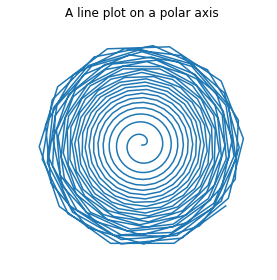

In [18]:

"""
Demo of a line plot on a polar axis.
"""
import numpy as np
import matplotlib.pyplot as plt


r = np.arange(0, 5, 0.01)
theta = 2 *np.pi* r**2

ax = plt.subplot(111, projection='polar')
ax.plot(theta, r)
# ax.set_rmax(2)
# ax.set_rticks([0.5, 1, 1.5, 2])  # less radial ticks
# ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.grid(True)
plt.axis('off')

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

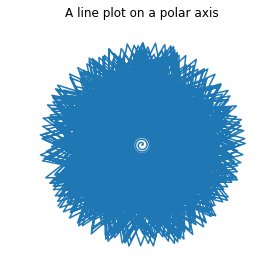

In [19]:
r = np.arange(0, 20, 0.01)
theta = 2 *np.pi* r**2

ax = plt.subplot(111, projection='polar')
ax.plot(theta, r)
# ax.set_rmax(2)
# ax.set_rticks([0.5, 1, 1.5, 2])  # less radial ticks
# ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.grid(True)
plt.axis('off')

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

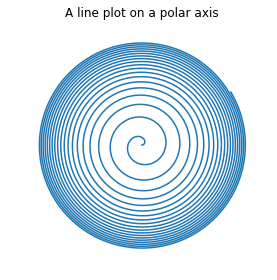

In [25]:
r = np.linspace(0, 3, 10000)
theta = 2 *np.pi* np.exp(r)

ax = plt.subplot(111, projection='polar')
ax.plot(theta, r)
# ax.set_rmax(2)
# ax.set_rticks([0.5, 1, 1.5, 2])  # less radial ticks
# ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.grid(True)
plt.axis('off')

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

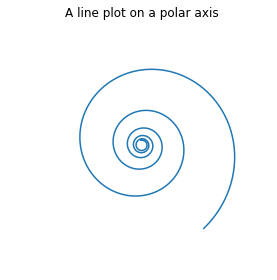

In [96]:
phi = (1. + np.sqrt(5.))/2.

b = 1.0053611

r = np.linspace(1,100, 1000)
theta = ((np.pi/2)/np.log(phi))*np.log(r*10)
#r = b**theta

ax = plt.subplot(111, projection='polar')
ax.plot(theta, r)
# ax.set_rmax(2)
# ax.set_rticks([0.5, 1, 1.5, 2])  # less radial ticks
# ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.grid(True)
plt.axis('off')

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

In [84]:
np.log(phi)/(np.pi/2)

0.30634896253003313

In [51]:
r

array([  2.12862363e-02,   2.14509251e-02,   2.16168882e-02,
         2.17841353e-02,   2.19526764e-02,   2.21225215e-02,
         2.22936806e-02,   2.24661639e-02,   2.26399818e-02,
         2.28151444e-02,   2.29916623e-02,   2.31695459e-02,
         2.33488057e-02,   2.35294524e-02,   2.37114968e-02,
         2.38949496e-02,   2.40798218e-02,   2.42661243e-02,
         2.44538682e-02,   2.46430647e-02,   2.48337249e-02,
         2.50258603e-02,   2.52194822e-02,   2.54146021e-02,
         2.56112316e-02,   2.58093824e-02,   2.60090663e-02,
         2.62102952e-02,   2.64130809e-02,   2.66174355e-02,
         2.68233712e-02,   2.70309002e-02,   2.72400348e-02,
         2.74507875e-02,   2.76631707e-02,   2.78771972e-02,
         2.80928795e-02,   2.83102305e-02,   2.85292632e-02,
         2.87499904e-02,   2.89724254e-02,   2.91965814e-02,
         2.94224716e-02,   2.96501095e-02,   2.98795086e-02,
         3.01106826e-02,   3.03436451e-02,   3.05784100e-02,
         3.08149913e-02,

In [98]:
from math import *
from PIL import Image as I, ImageDraw as D
n=eval(input())
G=(1+5**.5)/2
w=int(G**(4*(n//4)))
i=I.new("RGB",(w,w),"white")
d=D.Draw(i)
k=pi/180
d.line([(G**(j/90)*cos(j*k)+w/2,G**(j/90)*sin(j*k)+w/2)for j in range(n*90)],fill=0)
i.save("s.png","PNG")

10
